In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
import torchvision.datasets as Dataset
import torchvision.transforms as transforms

# hyper parameters
h_img_channel = 3
h_batch_size = 40
h_img_size = [28, 28]
h_dimension = 10
h_lr = 0.001
h_rate = 0.7
h_decay = 0.8
h_epoch = 20
h_iter = 500

# Dataset

In [2]:
from torch.utils.data import Dataset
import torch
import os

class Face_Dataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.file_list = os.listdir(self.root)
        self.code_list = torch.zeros([len(self.file_list), h_dimension], dtype=torch.float)
        
    def __len__(self):
        return len(self.file_list)
        
    def __getitem__(self, idx):
        img = Image.open(self.root + str(idx+1).zfill(6) + ".jpg")
        
        if(self.transform is not None):
            img = self.transform(img)
        return idx, img, self.code_list[idx]
    
    def save_code(self, idx, code):
        self.code_list[idx] = code

# Data

In [3]:
transform = transforms.Compose([
    transforms.CenterCrop([200, 100]),
    transforms.Resize(h_img_size),
    transforms.ToTensor(),
])

trainset = Face_Dataset(root='../Dataset/celebrities/img/', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=h_batch_size, shuffle=False, num_workers=6)

# Autoencoder

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def block(input_dim, output_dim):
            return nn.Sequential(
                nn.Conv2d(input_dim, output_dim, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_dim),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
            )
        
        def dnn(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim * 3 * 3, 1024),
                nn.BatchNorm1d(1024),
                nn.ReLU(),
                nn.Linear(1024, h_dimension),
                nn.Softmax(dim=1)
            )
        
        self.layer1 = block(h_img_channel, 64)
        self.layer2 = block(64, 128)
        self.layer3 = block(128, 512)
        self.layer4 = dnn(512)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x.view(-1, 512 * 3 * 3))
        return x
        
encoder = Encoder().cuda()

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        def block(input_dim, output_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(input_dim, output_dim, 3, stride=2),
                nn.BatchNorm2d(output_dim),
                nn.ReLU()
            )
        
        self.layer1 = block(h_dimension, 64)
        self.layer2 = block(64, 128)
        self.layer3 = nn.Sequential(nn.Upsample(size = 14, mode='bilinear', align_corners=False),
                                    nn.Conv2d(128, 512, 3, stride=1, padding=1),
                                    nn.BatchNorm2d(512),
                                    nn.ReLU())
        self.layer4 = nn.Sequential(nn.Upsample(size = 28, mode='bilinear', align_corners=False),
                                    nn.Conv2d(512, h_img_channel, 3, stride=1, padding=1),
                                    nn.BatchNorm2d(h_img_channel),
                                    nn.Sigmoid())
        
    def forward(self, x):
        x = self.layer1(x.view(-1, h_dimension, 1, 1))
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
        
decoder = Decoder().cuda()

# Optimizer

In [9]:
loss_fn = nn.MSELoss()
loss_fn_E = nn.BCEWithLogitsLoss() 

optimizer_E = Adam(encoder.parameters(), lr=h_lr, betas=(0.5, 0.999))
optimizer_D = Adam(decoder.parameters(), lr=h_lr, betas=(0.5, 0.999))

# Training

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 64 3 3 3, but got 3-dimensional input of size [3, 28, 28] instead

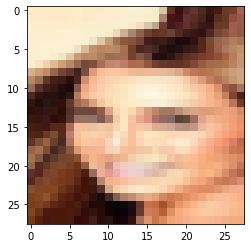

In [37]:
data = next(iter(trainloader))
plt.imshow(data[1].detach().detach().permute(0,2,3,1).cpu().numpy()[0], cmap='gray')

for epoch in range(h_epoch):
    """
    Train AE
    """
    optimizer_E.zero_grad()
    optimizer_D.zero_grad()

    imgs = data[1].cuda() 
    now_codes = encoder(imgs)
    outputs = decoder(now_codes)
    loss = loss_fn(outputs, imgs)
    loss.backward()
    optimizer_E.step()
    optimizer_D.step()

    print("[{:3d}/{:3d}] iter: {:4d}   loss: {:.6f}".
          format(epoch+1, h_epoch, i+1, loss.item()))
    plt.imshow(outputs.detach().detach().permute(0,2,3,1).cpu().numpy(), cmap='gray')
    plt.show()

In [7]:
for epoch in range(h_epoch):
    for i, data in enumerate(trainloader):
        """
        Train AE
        """
        optimizer_E.zero_grad()
        optimizer_D.zero_grad()
        
        img = data[1].cuda() 
        now_code = encoder(img)
        now_idx = torch.argsort(now_code, dim=1, descending=True)[:, :3]
        now_reward = torch.zeros([now_code.shape[0], now_code.shape[1]]).cuda().scatter_(dim=1, index=now_idx, value=1)
        
        past_reward = data[2].cuda()
        reward = h_rate * now_reward + (1 - h_rate) * h_decay * past_reward
        
        for j in range(now_code.shape[0]):
            trainset.save_code(data[0][j], reward[j])
        
        outputs = decoder(encoder(img))
        loss = loss_fn(outputs, img)
        loss.backward()
        optimizer_E.step()
        optimizer_D.step()
        
        if(i % h_iter == h_iter-1):
            print("[{:3d}/{:3d}] iter: {:4d}   loss: {:.6f}".
                  format(epoch+1, h_epoch, i+1, loss.item()))

[  1/ 20] iter:  500   loss: 0.022108
[  1/ 20] iter: 1000   loss: 0.018225
[  1/ 20] iter: 1500   loss: 0.018347
[  1/ 20] iter: 2000   loss: 0.020145
[  1/ 20] iter: 2500   loss: 0.018315
[  1/ 20] iter: 3000   loss: 0.016570
[  1/ 20] iter: 3500   loss: 0.017410
[  1/ 20] iter: 4000   loss: 0.016401
[  1/ 20] iter: 4500   loss: 0.017578
[  1/ 20] iter: 5000   loss: 0.015381
[  2/ 20] iter:  500   loss: 0.017421
[  2/ 20] iter: 1000   loss: 0.015367
[  2/ 20] iter: 1500   loss: 0.016067
[  2/ 20] iter: 2000   loss: 0.019001
[  2/ 20] iter: 2500   loss: 0.016821
[  2/ 20] iter: 3000   loss: 0.015735
[  2/ 20] iter: 3500   loss: 0.016315
[  2/ 20] iter: 4000   loss: 0.015921
[  2/ 20] iter: 4500   loss: 0.016910
[  2/ 20] iter: 5000   loss: 0.014963
[  3/ 20] iter:  500   loss: 0.016498
[  3/ 20] iter: 1000   loss: 0.014778
[  3/ 20] iter: 1500   loss: 0.015556
[  3/ 20] iter: 2000   loss: 0.018680
[  3/ 20] iter: 2500   loss: 0.016058
[  3/ 20] iter: 3000   loss: 0.015487
[  3/ 20] it

In [8]:
torch.save(encoder.state_dict(), 'encoder.pkl')
torch.save(decoder.state_dict(), 'decoder.pkl')

# Guiding code

In [10]:
for epoch in range(2):
    for i, data in enumerate(trainloader):
        optimizer_E.zero_grad()
        
        imgs, label_codes = data[1].cuda(), data[2].cuda()
        codes = encoder(imgs)
        loss_E = loss_fn_E(codes, label_codes)
        loss_E.backward()
        optimizer_E.step()
        
        outputs = decoder(encoder(imgs))
        loss_D = loss_fn(outputs, imgs)
        loss_D.backward()
        optimizer_D.step()
            
        if(i % h_iter == h_iter-1):
            print("[{:3d}/{:3d}] iter: {:4d}   loss_E: {:.6f}   loss_D {:.6f}".
                  format(epoch+1, h_epoch, i+1, loss_E.item(), loss_D.item()))

[  1/ 20] iter:  500   loss_E: 0.661970   loss_D 0.032162
[  1/ 20] iter: 1000   loss_E: 0.659922   loss_D 0.034533
[  1/ 20] iter: 1500   loss_E: 0.659872   loss_D 0.034875
[  1/ 20] iter: 2000   loss_E: 0.660024   loss_D 0.035657
[  1/ 20] iter: 2500   loss_E: 0.660405   loss_D 0.034721
[  1/ 20] iter: 3000   loss_E: 0.659878   loss_D 0.033014
[  1/ 20] iter: 3500   loss_E: 0.659587   loss_D 0.033110
[  1/ 20] iter: 4000   loss_E: 0.660312   loss_D 0.031284
[  1/ 20] iter: 4500   loss_E: 0.660753   loss_D 0.033370
[  1/ 20] iter: 5000   loss_E: 0.658430   loss_D 0.030164
[  2/ 20] iter:  500   loss_E: 0.659908   loss_D 0.030065
[  2/ 20] iter: 1000   loss_E: 0.658677   loss_D 0.031566
[  2/ 20] iter: 1500   loss_E: 0.658520   loss_D 0.032271
[  2/ 20] iter: 2000   loss_E: 0.658735   loss_D 0.034903
[  2/ 20] iter: 2500   loss_E: 0.659259   loss_D 0.033188
[  2/ 20] iter: 3000   loss_E: 0.658869   loss_D 0.031330
[  2/ 20] iter: 3500   loss_E: 0.658593   loss_D 0.030707
[  2/ 20] iter

# Test

tensor([9.6290e-24, 4.4221e-01, 1.0545e-13, 9.7314e-06, 2.1664e-02, 2.9426e-14,
        7.5020e-09, 5.3144e-01, 1.0164e-13, 4.6763e-03], device='cuda:0')
tensor([1.1847e-04, 4.4454e-18, 8.5165e-01, 1.2066e-10, 1.3550e-06, 9.9185e-04,
        4.6039e-05, 2.6870e-02, 8.4855e-08, 1.2032e-01], device='cuda:0')
tensor([8.0464e-01, 3.1687e-08, 4.5041e-08, 1.2462e-07, 2.8031e-06, 1.9340e-01,
        7.4218e-09, 8.1047e-08, 1.9453e-03, 1.8125e-05], device='cuda:0')
tensor([6.2415e-06, 3.2952e-05, 8.5517e-01, 3.9493e-04, 8.7099e-08, 1.3757e-09,
        1.4440e-01, 2.4744e-10, 3.4800e-11, 2.6651e-10], device='cuda:0')
tensor([2.2618e-08, 5.1704e-03, 7.1634e-07, 9.6477e-07, 2.0342e-01, 4.0260e-04,
        9.4253e-17, 1.2945e-04, 1.9297e-01, 5.9791e-01], device='cuda:0')
tensor([5.5642e-01, 4.3181e-01, 6.5816e-09, 2.3407e-07, 1.0949e-06, 2.5311e-09,
        3.6031e-03, 1.0031e-09, 8.1661e-03, 7.7576e-11], device='cuda:0')
tensor([5.2246e-01, 2.5938e-12, 1.5780e-02, 9.0951e-12, 1.7326e-07, 3.2058e-

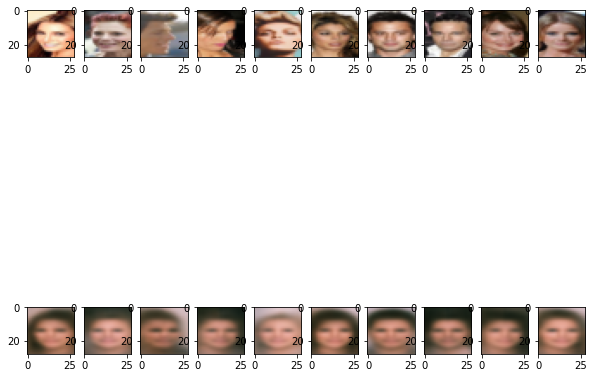

In [14]:
imgs = next(iter(trainloader))[1].cuda()
outputs = decoder(encoder(imgs))

input_imgs = imgs.detach().permute(0,2,3,1).squeeze().cpu().numpy()
output_imgs = outputs.detach().permute(0,2,3,1).squeeze().cpu().numpy()

fig, axes = plt.subplots(2, 10, figsize=(10, 10))
for i in range(10):
    print(encoder(imgs)[i].detach())
    axes[0, i].imshow(input_imgs[i], cmap='gray')
    axes[1, i].imshow(output_imgs[i], cmap='gray')

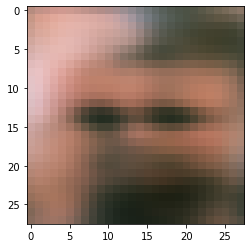

In [28]:
inputs = torch.Tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 0]).cuda()
outputs = decoder(inputs)
show_imgs = outputs.detach().permute(0,2,3,1).squeeze().cpu().numpy()
plt.imshow(show_imgs)
plt.show()